<a href="https://colab.research.google.com/github/marucha80t/application_of_universal_sentence_encoder/blob/master/unsupervised_extractive_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Extractive Summarization with EmbedRank
## Overview
This notebook demonstrates EmbedRank, which is an unsupervised keyphrase extraction model [1]. Sentence embeddings obtained from the Universal Sentence Encoder are used to calculate each sentence's importance.


## Settings

In [1]:
#@title Setup Environment
!pip install --quiet tensorflow==1.14.0
!pip install --quiet tensorflow_hub==0.5.0
!pip install --quiet tf_sentencepiece==0.1.82.1
!pip install --quiet googletrans==2.4.0
!pip install --quiet japanize-matplotlib==1.0.4
!pip install --quiet mecab-python3
!pip install --quiet https://github.com/megagonlabs/ginza/releases/download/v1.0.2/ja_ginza_nopn-1.0.2.tgz
!pip install --quiet https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz
    
!ln -s /usr/local/lib/python3.6/dist-packages/ja_ginza_nopn /usr/local/lib/python3.6/dist-packages/spacy/data/ja_ginza_nopn

     |████████████████████████████████| 2.8MB 2.8MB/s 
     |████████████████████████████████| 4.1MB 2.8MB/s 
     |████████████████████████████████| 15.9MB 2.8MB/s 
     |████████████████████████████████| 122.4MB 1.1MB/s 
     |████████████████████████████████| 27.7MB 1.8MB/s 
     |████████████████████████████████| 11.1MB 4.0MB/s 


In [2]:
#@title Setup common imports and functions
import tensorflow as tf
import tensorflow_hub as hub
import tf_sentencepiece
from googletrans import Translator
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import spacy
from IPython.display import HTML
from sklearn import manifold
%matplotlib inline


def ncossim(embs_1, embs_2, axis=0):
    sims = np.inner(embs_1, embs_2)
    std = np.std(sims, axis=axis)
    ex = np.mean((sims-np.min(sims, axis=axis))/np.max(sims, axis=axis), axis=axis)
    return 0.5 + (sims-ex)/std


def mmr(doc_emb, cand_embs, key_embs):
    param = 0.5
    scores = param * ncossim(cand_embs, doc_emb, axis=0)
    if key_embs is not None:
        scores -= (1-param) * np.max(ncossim(cand_embs, key_embs), axis=1).reshape(scores.shape[0], -1)
    return scores


def embedrank(doc_emb, sent_embs, n_keys):
    assert 0 < n_keys, 'Please `key_size` value set more than 0'
    assert n_keys < len(sent_embs), 'Please `key_size` value set lower than `#sentences`'
    sims = np.inner(doc_emb, sent_embs).reshape(-1)
    return np.argsort(-sims)[:n_keys]


def embedrankpp(doc_emb, sent_embs, n_keys):
    assert 0 < n_keys, 'Please `key_size` value set more than 0'
    assert n_keys < len(sent_embs), 'Please `key_size` value set lower than `#sentences`'
    cand_idx = list(range(len(sent_embs)))
    key_idx = []
    while len(key_idx) < n_keys:
        cand_embs = sent_embs[cand_idx]
        key_embs = sent_embs[key_idx] if len(key_idx) > 0 else None
        scores = mmr(doc_emb, cand_embs, key_embs)
        key_idx.append(cand_idx[np.argmax(scores)])
        cand_idx.pop(np.argmax(scores))
    return key_idx

W0729 06:17:28.036733 140591497373568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_sentencepiece/sentencepiece_processor_ops.py:259: The name tf.NotDifferentiable is deprecated. Please use tf.no_gradient instead.



## Extractive Summarization

In [0]:
#@title Build a model
encoder = 'universal-sentence-encoder-xling-many' #@param ["universal-sentence-encoder-multilingual", "multilingual-large", "universal-sentence-encoder-xling-many"]
if encoder == 'universal-sentence-encoder-xling-many':
    module_url = "https://tfhub.dev/google/universal-sentence-encoder-xling-many/1"
elif encoder == 'universal-sentence-encoder-multilingual':
    module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/1'
elif encoder == 'universal-sentence-encoder-multilingual-large':
    module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/1'


g = tf.Graph()
with g.as_default():
    text_input = tf.placeholder(dtype=tf.string, shape=[None])
    xling_embed = hub.Module(module_url)
    embedded_text = xling_embed(text_input)
    init_options = tf.group([tf.global_variables_initializer(), tf.tables_initializer()])
g.finalize()

session = tf.Session(graph=g)
session.run(init_options)

    
ranker = 'EmbedRank++' #@param ["EmbedRank", "EmbedRank++"]
rank_fn = embedrank if ranker == "EmbedRank" else embedrankpp

In [0]:
# Document from Wikipedia
doc = ["""
自動要約（じどうようやく）は、コンピュータプログラムを用いて、文書からその要約を作成する処理である。
作成される要約は、要約の対象となる文書の最も重要な要素のみを残しているべきであり、いわゆる情報のオーバーロードに伴い自動要約に対する関心も増している。
首尾一貫した要約を作成するためには要約の長さや書き方のスタイル、文法などといった点が考慮されなければならない。
自動要約の応用先の1つはGoogleなどの検索エンジンであるが、もちろん独立した1つの要約プログラムといったものもありうる。
自動要約は、要約の目的や要約の対象とする文書の数、要約の方法などによっていくつかの種類に分類することができる。
抽出的要約は、要約の対象となる文書に含まれる単語や句、文といった単位をうまく抽出し、それらを組み合わせることで要約を作成する。
一方、生成的要約は、文書を一度何らかの中間表現（あるいは意味表現）に変換し、この中間表現を元に自然言語生成の技術を用いて要約を作成する。
そのため、生成的要約によって作成された要約には元の文書に含まれていない表現が含まれることもありうる。
生成的要約には、文書を中間表現に正確に変換すること（すなわち、精度の高い自然言語理解を実現すること）、そこから要約を生成するための自然言語生成器が必要になるといった問題が存在するため、もっぱら研究の焦点は抽出的要約にあてられている。
"""]


In [5]:
#@title Language detection and sentence segmentation
translator = Translator()
detected_lang = translator.detect(''.join(doc))

assert detected_lang.lang in ['ja', 'en'], 'Please, input Japanese text or English text'
if detected_lang.lang == 'ja':
    tokenizer = spacy.load('ja_ginza_nopn')
elif detected_lang.lang == 'en':
    tokenizer = spacy.load('en_core_web_sm')

sents = [str(s).replace('\n', '') for s in tokenizer(''.join(doc)).sents]
print(f'Language: {detected_lang.lang}')
print(f'#sentences: {len(sents)}')

Language: ja
#sentences: 9


In [0]:
#@title Model run
key_size = 3 #@param {type:"integer"}

# Embedding
doc_emb= session.run(embedded_text, feed_dict={text_input: doc})
sent_embs= session.run(embedded_text, feed_dict={text_input: sents})

# Ranking
keys = rank_fn(doc_emb, sent_embs, key_size)

In [7]:
#@title Display
display_sents = []
for i, s in enumerate(sents):
    line = '<font color="#CD5C5C"><strong>' + s + '</strong></font>' if i in keys else s
    display_sents.append(line)
HTML(''.join(display_sents))


id	sentence
1	 自動要約（じどうようやく）は、コンピュータプログラムを用いて、文書からその要約を作成する処理である...
2	作成される要約は、要約の対象となる文書の最も重要な要素のみを残しているべきであり、いわゆる情報のオー...
3	首尾一貫した要約を作成するためには要約の長さや書き方のスタイル、文法などといった点が考慮されなければ...
4	自動要約の応用先の1つはGoogleなどの検索エンジンであるが、もちろん独立した1つの要約プログラム...
5	自動要約は、要約の目的や要約の対象とする文書の数、要約の方法などによっていくつかの種類に分類すること...
6	抽出的要約は、要約の対象となる文書に含まれる単語や句、文といった単位をうまく抽出し、それらを組み合わ...
7	一方、生成的要約は、文書を一度何らかの中間表現（あるいは意味表現）に変換し、この中間表現を元に自然言...
8	そのため、生成的要約によって作成された要約には元の文書に含まれていない表現が含まれることもありうる。...
9	生成的要約には、文書を中間表現に正確に変換すること（すなわち、精度の高い自然言語理解を実現すること）...



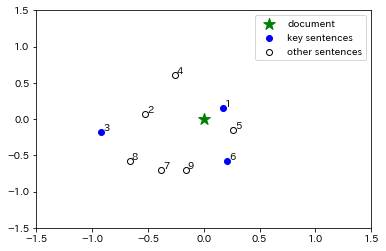

In [8]:
#@title Visualize sentence embeddings

# print sentences
print('id' + '\t' + 'sentence')
for i, sent in enumerate(sents, 1):
    if len(sent) < 50:
        print(str(i) + '\t' + sent)
    else:
        print(str(i) + '\t' + sent[:50] + '...')
print('')

# MDS
mds = manifold.MDS(n_components=2, dissimilarity="euclidean")
embs = np.concatenate((doc_emb, sent_embs), 0)
pns = mds.fit_transform(embs)
fixed_pns = pns - pns[0]

# plot
keys_idx = [idx + 1 for idx in keys]
other_idx = [idx for idx in range(1, len(sents)+1) if idx not in keys_idx]
plt.scatter(fixed_pns[0,0], fixed_pns[0,1], color='green',  marker='*', s=150, label='document')
plt.scatter(fixed_pns[keys_idx,0], fixed_pns[keys_idx, 1], color='blue', label='key sentences')
plt.scatter(fixed_pns[other_idx,0], fixed_pns[other_idx, 1], color='white', edgecolors='black', label='other sentences')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

for i,(x,y) in enumerate(fixed_pns[1:], 1):
    plt.annotate(str(i), (x+0.02,y+0.02))
    
plt.legend()
plt.show()


## References
1. [Kamil Bennani-Smires, Claudiu Musat, Andreaa Hossmann, Michael Baeriswyl, Martin Jaggi. Simple Unsupervised Keyphrase Extraction using Sentence Embeddings. CoNLL 2018, pages 221–229](https://www.aclweb.org/anthology/K18-1022)


